In [1]:
# %pip install yfinance numpy pandas scikit-learn matplotlib statsmodels

In [2]:
# %pip install statsmodels
# %pip install xgboost
# %pip install lightgbm
# %pip install keras
# %pip install tensorflow
# %pip install arch
# %pip install --upgrade keras
# %pip install twelvedata

In [3]:
import yfinance as yf
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt

# X = "EURUSD=X"
# Y = "GBPUSD=X"
X = "PARA"
Y = "LYV"

df = yf.download([X, Y], start="2010-01-01", end="2025-01-01")["Close"]
df.dropna(inplace=True)
df.head()

C:\Users\jayes\AppData\Local\Temp\ipykernel_10120\267213003.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download([X, Y], start="2010-01-01", end="2025-01-01")["Close"]
[*********************100%***********************]  2 of 2 completed


Ticker,LYV,PARA
Date,,
2010-01-04,9.12,10.866109
2010-01-05,9.35,10.812734
2010-01-06,9.95,10.469594
2010-01-07,9.70,10.675472
2010-01-08,9.64,10.789856


In [4]:
from statsmodels.tsa.stattools import coint

score, p_value, _ = coint(df[X], df[Y])
if p_value < 0.05:
    print(f"{X} and {Y} are cointegrated with p-value: {p_value:.4f}")

In [5]:
plt.style.available
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'svg'

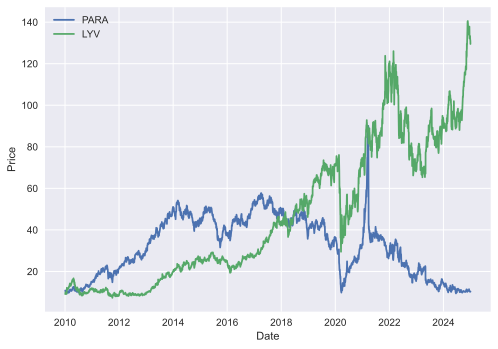

In [6]:
plt.plot(df.copy().copy().copy().copy()[X], label=X)
plt.plot(df[Y], label=Y)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [7]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
a_X = sm.add_constant(df[X])
model = OLS(df[Y], a_X).fit()
# beta = model.params[X]
# alpha = model.params['const']
df["Y_pred"] = model.predict(a_X)
df["Spread"] = df[Y] - df["Y_pred"]


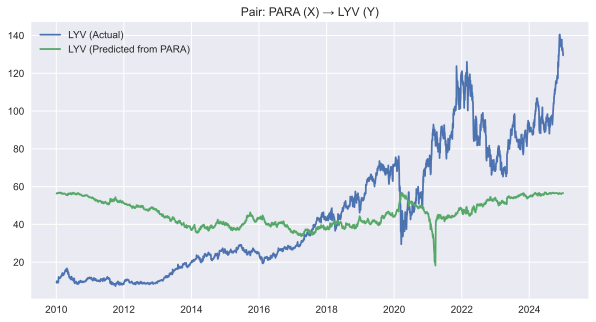

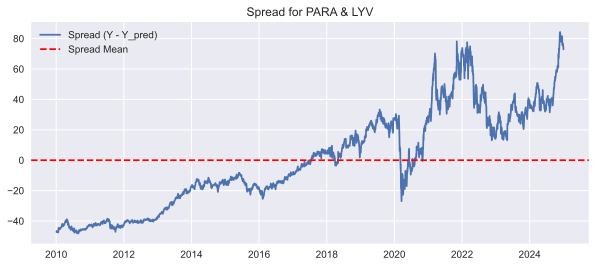

In [8]:

plt.figure(figsize=(10, 5))
plt.plot(df.index, df[Y], label=f"{Y} (Actual)")
plt.plot(df.index, df["Y_pred"], label=f"{Y} (Predicted from {X})")
plt.title(f"Pair: {X} (X) → {Y} (Y)")
plt.legend()


plt.figure(figsize=(10, 4))
plt.plot(df.index, df["Spread"], label="Spread (Y - Y_pred)")
plt.axhline(df["Spread"].mean(), color='red', linestyle='--', label="Spread Mean")
plt.title(f"Spread for {X} & {Y}")
plt.legend()

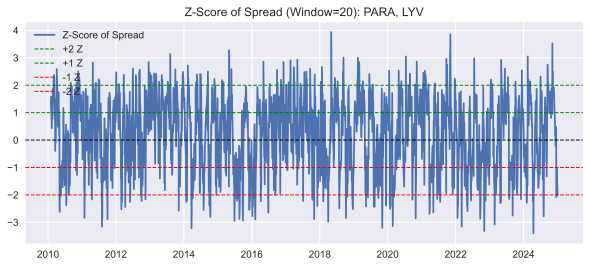

In [9]:

# Compute rolling mean, rolling std, and Z-score for the spread
window_size=20
df["Spread_mean_MA"] = df["Spread"].rolling(window_size).mean()
df["Spread_STD"] = df["Spread"].rolling(window_size).std()
df["Zscore"] = (df["Spread"] - df["Spread_mean_MA"]) / df["Spread_STD"]

# Visualize the Z-score
plt.figure(figsize=(10, 4))
plt.plot(df.index, df["Zscore"], label="Z-Score of Spread")
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.axhline(2.0, color="green", linestyle="--", lw=1, label="+2 Z")
plt.axhline(1.0, color="green", linestyle="--", lw=1, label="+1 Z")
plt.axhline(-1.0, color="red", linestyle="--", lw=1, label="-1 Z")
plt.axhline(-2.0, color="red", linestyle="--", lw=1, label="-2 Z")
plt.title(f"Z-Score of Spread (Window={window_size}): {X}, {Y}")
plt.legend()
plt.show()

In [10]:
window=5
df["Spread_MA_diff"] = df["Spread"] - df["Spread_mean_MA"]
df["Zscore_diff"] = df["Zscore"].diff()
df["Spread_return"] = df["Spread"].pct_change()
lambda_ = 0.94
df["Spread_ewma_vol"] = df["Spread"].ewm(span=(2/(1-lambda_)-1)).std()
# Mean reversion happened if Z-score moved closer to zero within N days
current_z = df["Zscore"]
future_z = df["Zscore"].shift(-window)
df["is_entry_zone"] = (df["Zscore"].abs() > 1).astype(int)

df["target"] = ((abs(abs(current_z) - abs(future_z)) > 0.5) & (abs(current_z) > abs(future_z))).astype(int)
df.dropna(inplace=True)
df


Ticker,LYV,PARA,Y_pred,Spread,Spread_mean_MA,Spread_STD,Zscore,Spread_MA_diff,Zscore_diff,Spread_return,Spread_ewma_vol,is_entry_zone,target
Date,,,,,,,,,,,,,
2010-02-02,11.490000,10.027320,56.717379,-45.227379,-46.442990,1.014789,1.197895,1.215611,-0.227854,0.002024,1.088756,1,0
2010-02-03,11.890000,10.484838,56.497243,-44.607243,-46.323879,1.084671,1.582633,1.716636,0.384738,-0.013712,1.135534,1,1
2010-02-04,11.660000,9.951070,56.754067,-45.094067,-46.250853,1.117004,1.035614,1.156786,-0.547019,0.010914,1.122712,1,1
2010-02-05,11.910000,9.874818,56.790756,-44.880756,-46.159615,1.151892,1.110225,1.278859,0.074610,-0.004730,1.120719,1,0
2010-02-08,11.630000,9.699433,56.875143,-45.245143,-46.086348,1.161570,0.724196,0.841205,-0.386029,0.008119,1.091822,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,133.320007,10.331800,56.570877,76.749130,79.365277,2.349087,-1.113687,-2.616147,0.421090,0.011244,8.414776,1,0
2024-12-26,133.350006,10.351631,56.561336,76.788670,79.085638,2.303585,-0.997127,-2.296968,0.116560,0.000515,8.163712,0,0
2024-12-27,131.850006,10.311970,56.580419,75.269587,78.683957,2.228654,-1.532032,-3.414370,-0.534905,-0.019783,7.915529,1,0


In [11]:
from sklearn.model_selection import train_test_split
# Getting features and target
df_cond = df[df['is_entry_zone'] == 1]
features = ["Spread", "Zscore", "Spread_STD", "Spread_MA_diff", "Zscore_diff", "Spread_return", "Spread_ewma_vol"]
X = df_cond[features]
y = df_cond["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [12]:
# ---Comparison: Random Forest, XGBoost, LightGB---
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings
warnings.filterwarnings('ignore')

models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    "LightGBM": LGBMClassifier(verbosity = -1)
}

best_acc = -1
best_model = None
best_name = None
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"\nModel: {name} \nAccuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_name = name
        
print(best_name, best_acc)


Model: Random Forest 
Accuracy: 0.6119
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       217
           1       0.56      0.71      0.63       185

    accuracy                           0.61       402
   macro avg       0.62      0.62      0.61       402
weighted avg       0.63      0.61      0.61       402


Model: XGBoost 
Accuracy: 0.6045
              precision    recall  f1-score   support

           0       0.65      0.57      0.61       217
           1       0.56      0.65      0.60       185

    accuracy                           0.60       402
   macro avg       0.61      0.61      0.60       402
weighted avg       0.61      0.60      0.60       402


Model: LightGBM 
Accuracy: 0.6318
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       217
           1       0.58      0.71      0.64       185

    accuracy                           0.63       402
   macro avg       

In [13]:
# --- LSTM ---
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

target = "target"
data = df_cond[features + [target]].values

# Normalize features
split_idx = int(len(df_cond)*0.8)
df_train = df_cond.iloc[:split_idx]
df_test = df_cond.iloc[split_idx:]

# 2) Fitting scaler only on df_train, transform both
scaler = MinMaxScaler().fit(df_train[features + [target]])
train_scaled = scaler.transform(df_train[features + [target]])
test_scaled = scaler.transform(df_test[features + [target]])

# Separate generators
# Train generator and test generator
X_train_seq, y_train_seq = train_scaled[:, :-1], train_scaled[:, -1]
X_test_seq, y_test_seq = test_scaled[:, :-1], test_scaled[:, -1]


n_input = 5  

test_gen = TimeseriesGenerator(X_test_seq, y_test_seq, length=n_input, batch_size=len(X_test_seq))


# Build LSTM model
lstm_model = Sequential()
# Use default tanh/sigmoid internals for stability:
lstm_model.add(LSTM(50, input_shape=(n_input, X_train_seq.shape[1])))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

train_gen = TimeseriesGenerator(X_train_seq, y_train_seq, length=n_input, batch_size=32)
val_gen = TimeseriesGenerator(X_test_seq, y_test_seq, length=n_input, batch_size=32)
# Add early stopping and more epochs for robust training

lstm_model.fit(train_gen, validation_data=val_gen, epochs=10, batch_size=32, verbose=1)

# 1) Scale your test set with the SAME scaler
test_scaled = scaler.transform(df_test[features + [target]])

# 2) Build a test generator exactly like your train/val ones
X_test_seq = test_scaled[:, :-1];  y_test_seq = test_scaled[:, -1]
test_gen = TimeseriesGenerator(X_test_seq, y_test_seq, length=n_input, batch_size=len(X_test_seq))

# 3) Predict and align
y_pred_prob = lstm_model.predict(test_gen).ravel()
y_pred      = (y_pred_prob > 0.5).astype(int)
y_true      = y_test_seq[n_input:]   


print("Evaluation Metrics for LSTM:")
print(f"Accuracy  : {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision : {precision_score(y_true, y_pred):.4f}")
print(f"Recall    : {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score  : {f1_score(y_true, y_pred):.4f}")


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.4993 - loss: 0.6930 - val_AUC: 0.5545 - val_loss: 0.7026
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.5015 - loss: 0.6925 - val_AUC: 0.5953 - val_loss: 0.6942
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.4753 - loss: 0.6917 - val_AUC: 0.5826 - val_loss: 0.6924
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.4857 - loss: 0.6914 - val_AUC: 0.5729 - val_loss: 0.6966
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5166 - loss: 0.6929 - val_AUC: 0.5667 - val_loss: 0.7002
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.4905 - loss: 0.6898 - val_AUC: 0.5754 - val_loss: 0.6921
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5219 - loss: 0.6903 - val_AUC: 0.5759 - val_loss: 0.6980
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5151 - loss: 0.6921 - val_AUC: 0.5654 - val_loss: 0.6994
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5071 - loss: 

In [14]:
# --- ARIMA Forecasting ---
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(df["Spread"], order=(1, 1, 1))
arima_result = arima_model.fit()
df["ARIMA_Forecast"] = arima_result.predict()
print("\nARIMA model fitted and forecast saved to df['ARIMA_Forecast']")


ARIMA model fitted and forecast saved to df['ARIMA_Forecast']


In [15]:
# --- GARCH Volatility Forecasting ---
from arch import arch_model

returns = df["Spread"].pct_change().dropna()
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')
df_garch = df.loc[returns.index]  # Align indexes
df_garch['GARCH_volatility'] = garch_result.conditional_volatility
df['GARCH_volatility'] = df_garch['GARCH_volatility']
print("\nGARCH volatility forecast saved to df_garch['GARCH_volatility']")


GARCH volatility forecast saved to df_garch['GARCH_volatility']


In [16]:
import numpy as np

def backtest_with_model(df, df_cond, model=None, use_arima=False, use_garch=False, use_lstm=False):
    from sklearn.metrics import classification_report
    import pandas as pd
    df_cond['model_signal'] = 0
    df['model_signal']      = 0
    p1 = "PARA"
    p2 = "LYV"
    features = ["Zscore", "Spread_STD", "Spread_MA_diff", "Zscore_diff", "Spread_return", "Spread_ewma_vol"]
    df = df.dropna(subset=features + (['ARIMA_Forecast'] if use_arima else []) + (['GARCH_volatility'] if use_garch else []))
    # Get model predictions
    # ─── Generate entry signals ───
    if use_lstm:
        split_idx = int(len(df_cond)*0.8)
        df_train = df_cond.iloc[:split_idx]
        df_test = df_cond.iloc[split_idx:]

        scaler = MinMaxScaler().fit(df_train[features + [target]])
        train_scaled = scaler.transform(df_train[features + [target]])
        test_scaled = scaler.transform(df_test[features + [target]])

        # 3) Build separate generators
        X_train_seq, y_train_seq = train_scaled[:, :-1], train_scaled[:, -1]
        X_test_seq, y_test_seq = test_scaled[:, :-1], test_scaled[:, -1]
        
        n_input = 5  

        test_gen = TimeseriesGenerator(X_test_seq, y_test_seq, length=n_input, batch_size=len(X_test_seq))

        # Build LSTM model
        lstm_model = Sequential()
        # Use default tanh/sigmoid internals for stability:
        lstm_model.add(LSTM(50, input_shape=(n_input, X_train_seq.shape[1])))
        lstm_model.add(Dense(1, activation='sigmoid'))
        lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

        train_gen = TimeseriesGenerator(X_train_seq, y_train_seq, length=n_input, batch_size=32)
        val_gen = TimeseriesGenerator(X_test_seq, y_test_seq, length=n_input, batch_size=32)
        # Add early stopping and more epochs for robust training

        lstm_model.fit(train_gen, validation_data=val_gen, epochs=10, batch_size=32, verbose=-1)
        
        y_sig = (lstm_model.predict(test_gen).ravel() > 0.5).astype(int)

        # Ensure lengths match: only keep the last len(y_sig) rows of df_test
        pred_indices = df_test.index[-len(y_sig):]

        # Assign predictions to these rows
        df_cond.loc[pred_indices, 'model_signal'] = y_sig

    elif model:
        X = df_cond[features]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        model.fit(X_train, y_train)
        # Predict on the test slice
        y_pred = model.predict(X_test)

        # Only overwrite those test‑period rows in df_cond
        df_cond.loc[X_test.index, "model_signal"] = y_pred
    else:
        # Baseline: simple z‑score crossings
        df_cond["model_signal"] = 0
        df_cond.loc[df["Zscore"] > 1, "model_signal"] = -1
        df_cond.loc[df["Zscore"] < -1, "model_signal"] = +1


    # Simulate trading
    cash = 10000
    position = 0  # +1 for long, -1 for short
    entry_price = 0
    alloc_per_leg = 0.5
    returns = []
    equity_curve = [cash]
    drawdowns = []
    df["model_signal"] = df_cond["model_signal"].reindex(df.index, fill_value=0).astype(int)

    for i in range(len(df)):
        signal = df["model_signal"].iloc[i]
        z = df['Zscore'].iloc[i]
        price1 = df[p1].iloc[i]
        price2 = df[p2].iloc[i]
        if use_garch and df["GARCH_volatility"].iloc[i] > df["GARCH_volatility"].mean():
            equity_curve.append(cash)
            continue
        if position == 0:
            if signal == 1:
                position = 1
                invested = cash * alloc_per_leg
                qty_short = invested // price1
                qty_long  = invested // price2
                short_entry_price = price1
                long_entry_price = price2
            elif signal == -1:
                position = -1
                invested = cash * alloc_per_leg
                qty_short = invested // price2
                qty_long  = invested // price1
                short_entry_price = price2
                long_entry_price = price1

        elif position == 1:
    
            if z > -0.5:
                long_exit_price = price2
                short_exit_price = price1
                profit = (long_exit_price - long_entry_price)*qty_long + (short_entry_price - short_exit_price)+qty_short
                cash += profit
                returns.append(profit)
                position = 0
            
        elif position == -1:
            if z < 0.5:
                short_exit_price = price2
                long_exit_price = price1
                profit = (long_exit_price - long_entry_price)*qty_long + (short_entry_price - short_exit_price)*qty_short
                cash += profit
                returns.append(profit)
                position = 0

        equity_curve.append(cash)


    if len(returns) == 0:
        print("No trades executed.")
        return

    # ---- METRICS ---
    equity = np.array(equity_curve)
    trades = np.array(returns)
    total_return   = equity[-1]/equity[0] - 1
    cagr           = (1 + total_return) ** (252/len(equity)) - 1
    sharpe         = trades.mean()/trades.std()*np.sqrt(252)
    drawdowns      = equity - np.maximum.accumulate(equity)
    max_dd         = drawdowns.min()
    win_rate       = (trades>0).mean()
    avg_profit     = trades[trades>0].mean()
    avg_loss       = trades[trades<0].mean()
    # avg_drawdown = np.mean(drawdown)
    profit_factor  = trades[trades>0].sum() / -trades[trades<0].sum()
    tot_profit = np.sum(trades)

    print(f"Total Return   : {total_return:.2%}")
    print(f"CAGR           : {cagr:.2%}")
    print(f"Sharpe Ratio   : {sharpe:.2f}")
    print(f"Max Drawdown   : {max_dd:.2f}")
    print(f"Win Rate       : {win_rate:.2%}")
    print(f"Avg. Profit/Loss: {avg_profit:.2f}/{avg_loss:.2f}")
    # print(f"Avg. Drawdown: {avg_drawdown:.2f}")
    print(f"Profit Factor  : {profit_factor:.2f}")
    print(f"Total Profit: {tot_profit:.2f}")

scenarios = [
    ("Baseline Rule",         None,           False, False, False),
    ("Tree-Based ML",         best_model,     False, False, False),
    ("Sequence Model (LSTM)", None,           False, False, True),
    ("Hybrid ML + LSTM",      best_model,     False, False, True),
    ("Regime-Filtered",       best_model,     False, True,  False),
]


for idx, (name, model, use_arima, use_garch, use_lstm) in enumerate(scenarios, 1):
    print(f"\n--- BACKTEST SCENARIO {idx}: {name} ---")
    backtest_with_model(df.copy(), df_cond.copy(), model=model, use_arima=use_arima, use_garch=use_garch, use_lstm=use_lstm)



--- BACKTEST SCENARIO 1: Baseline Rule ---


Total Return   : 3575.86%
CAGR           : 27.37%
Sharpe Ratio   : 2.35
Max Drawdown   : -73865.69
Win Rate       : 69.09%
Avg. Profit/Loss: 3532.00/-4244.09
Profit Factor  : 1.86
Total Profit: 357586.23

--- BACKTEST SCENARIO 2: Tree-Based ML ---
Total Return   : 2866.34%
CAGR           : 25.55%
Sharpe Ratio   : 12.87
Max Drawdown   : -551.36
Win Rate       : 96.84%
Avg. Profit/Loss: 3127.66/-370.26
Profit Factor  : 259.05
Total Profit: 286633.88

--- BACKTEST SCENARIO 3: Sequence Model (LSTM) ---
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Total Return   : 27623.07%
CAGR           : 45.86%
Sharpe Ratio   : 9.16
Max Drawdown   : -569.24
Win Rate       : 98.05%
Avg. Profit/Loss: 18302.11/-437.30
Profit Factor  : 2106.56
Total Profit: 2762306.55

--- BACKTEST SCENARIO 4: Hybrid ML + LSTM ---
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoc